Using device: cuda
Running benchmarks for batch_size=128...
Running benchmarks for batch_size=256...
Running benchmarks for batch_size=384...
Running benchmarks for batch_size=512...
Running benchmarks for batch_size=640...
Running benchmarks for batch_size=768...
Running benchmarks for batch_size=896...
Running benchmarks for batch_size=1024...
Running benchmarks for batch_size=2000...
Running benchmarks for batch_size=5000...
Running benchmarks for batch_size=10000...


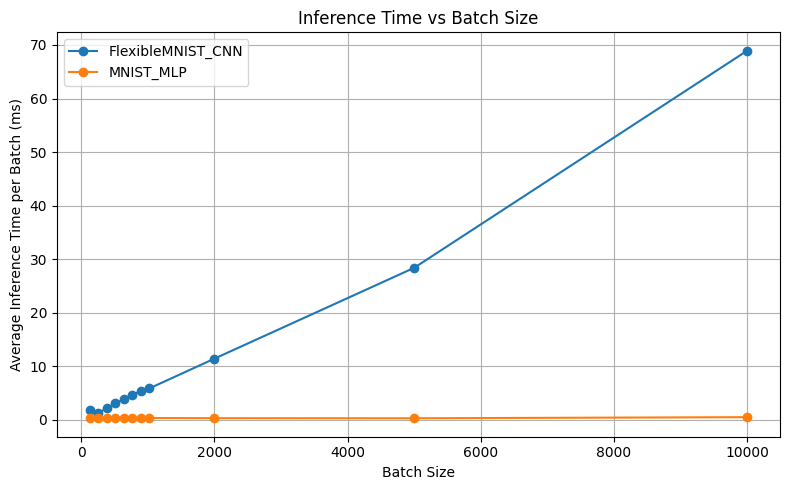

In [5]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ------------------------------
# Define Models
# ------------------------------

class FlexibleMNIST_CNN(nn.Module):
    def __init__(
        self,
        conv_channels=None,
        kernel_size=3,
        fc_dims=None,
        seed=None
    ):
        super(FlexibleMNIST_CNN, self).__init__()
        
        self.conv_channels = conv_channels or [32, 64]
        self.kernel_size = kernel_size
        self.fc_dims = fc_dims or [128]

        if seed is not None:
            with torch.random.fork_rng():
                torch.manual_seed(seed)
                self._initialize_layers()
        else:
            self._initialize_layers()

    def _initialize_layers(self):
        layers = []
        in_channels = 1
        
        for out_channels in self.conv_channels:
            layers.append(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=self.kernel_size,
                    padding=self.kernel_size // 2,
                )
            )
            layers.append(nn.ReLU())
            in_channels = out_channels
        
        self.conv_layers = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(2, 2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            conv_out = self.pool(self.conv_layers(dummy_input))
            flat_dim = conv_out.view(1, -1).shape[1]

        fc_layers = []
        input_dim = flat_dim
        for h in self.fc_dims:
            fc_layers.append(nn.Linear(input_dim, h))
            fc_layers.append(nn.ReLU())
            input_dim = h
        fc_layers.append(nn.Linear(input_dim, 10))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


class MNIST_MLP(nn.Module):
    def __init__(self, hidden_dims=None, seed=None):
        super(MNIST_MLP, self).__init__()
        hidden_dims = hidden_dims or [256, 128]
        self.hidden_dims = hidden_dims

        if seed is not None:
            with torch.random.fork_rng():
                torch.manual_seed(seed)
                self._initialize_layers()
        else:
            self._initialize_layers()

    def _initialize_layers(self):
        layers = []
        input_dim = 28 * 28
        for h in self.hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

# ------------------------------
# Benchmark Function
# ------------------------------

def benchmark_model(model, device="cpu", batch_size=128, warmup=10, runs=100):
    model = model.to(device)
    model.eval()

    if device == "cuda":
        torch.cuda.synchronize()

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            x = torch.randn(batch_size, 1, 28, 28, device=device)
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            x = torch.randn(batch_size, 1, 28, 28, device=device)
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    return (end - start) / runs


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    cnn = FlexibleMNIST_CNN()
    mlp = MNIST_MLP()

    batch_sizes = [128, 256, 384, 512, 640, 768, 896, 1024, 2000, 5000, 10000]
    cnn_times = []
    mlp_times = []

    for bs in batch_sizes:
        print(f"Running benchmarks for batch_size={bs}...")
        cnn_time = benchmark_model(cnn, device=device, batch_size=bs, runs=100)
        mlp_time = benchmark_model(mlp, device=device, batch_size=bs, runs=100)
        cnn_times.append(cnn_time)
        mlp_times.append(mlp_time)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(batch_sizes, [t * 1000 for t in cnn_times], "-o", label="FlexibleMNIST_CNN")
    plt.plot(batch_sizes, [t * 1000 for t in mlp_times], "-o", label="MNIST_MLP")
    plt.xlabel("Batch Size")
    plt.ylabel("Average Inference Time per Batch (ms)")
    plt.title("Inference Time vs Batch Size")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Using device: cuda
Running benchmarks for batch_size=128...
  CNN: 0.62ms, MLP: 0.30ms
Running benchmarks for batch_size=256...
  CNN: 0.51ms, MLP: 0.30ms
Running benchmarks for batch_size=384...
  CNN: 0.73ms, MLP: 0.29ms
Running benchmarks for batch_size=512...
  CNN: 1.27ms, MLP: 0.32ms
Running benchmarks for batch_size=640...
  CNN: 2.04ms, MLP: 0.30ms
Running benchmarks for batch_size=768...
  CNN: 2.04ms, MLP: 0.29ms
Running benchmarks for batch_size=896...
  CNN: 4.68ms, MLP: 0.30ms
Running benchmarks for batch_size=1024...
  CNN: 4.69ms, MLP: 0.40ms
Running benchmarks for batch_size=2000...
  CNN: 9.08ms, MLP: 0.30ms
Running benchmarks for batch_size=5000...
  CNN: 23.00ms, MLP: 0.30ms
Running benchmarks for batch_size=10000...
  CNN: 30.06ms, MLP: 0.41ms


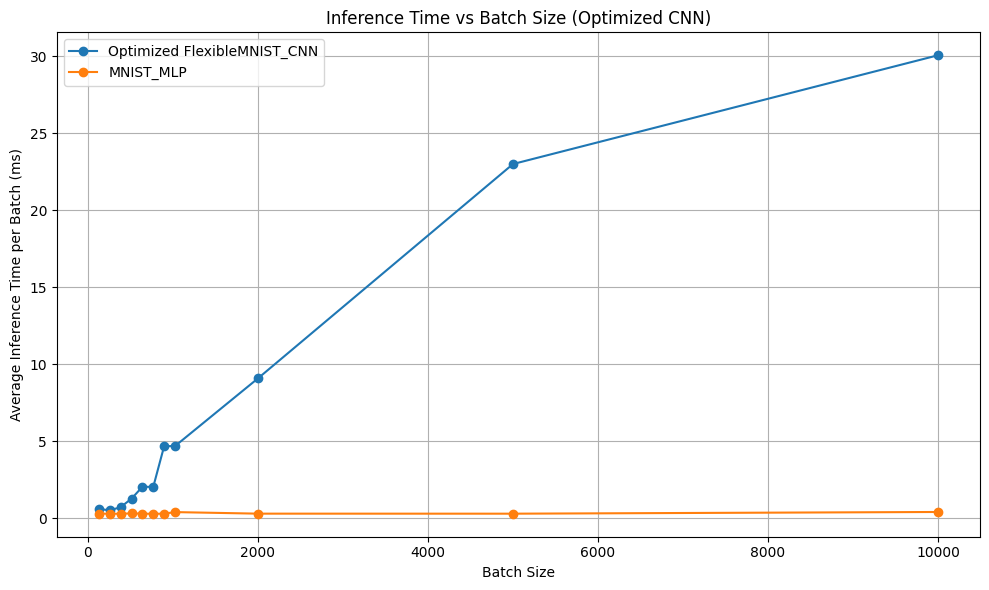


Performance Summary:
Batch 128: CNN=0.62ms, MLP=0.30ms
Batch 256: CNN=0.51ms, MLP=0.30ms
Batch 384: CNN=0.73ms, MLP=0.29ms
Batch 512: CNN=1.27ms, MLP=0.32ms
Batch 640: CNN=2.04ms, MLP=0.30ms
Batch 768: CNN=2.04ms, MLP=0.29ms
Batch 896: CNN=4.68ms, MLP=0.30ms
Batch 1024: CNN=4.69ms, MLP=0.40ms
Batch 2000: CNN=9.08ms, MLP=0.30ms
Batch 5000: CNN=23.00ms, MLP=0.30ms
Batch 10000: CNN=30.06ms, MLP=0.41ms


In [6]:
# ------------------------------
# Define Optimized Models
# ------------------------------

class FlexibleMNIST_CNN(nn.Module):
    def __init__(
        self,
        conv_channels=None,
        kernel_size=3,
        fc_dims=None,
        seed=None
    ):
        super(FlexibleMNIST_CNN, self).__init__()
        
        self.conv_channels = conv_channels or [32, 64]
        self.kernel_size = kernel_size
        self.fc_dims = fc_dims or [128]
        self.flat_dim = None  # Cache the flattened dimension

        if seed is not None:
            with torch.random.fork_rng():
                torch.manual_seed(seed)
                self._initialize_layers()
        else:
            self._initialize_layers()

    def _calculate_flat_dim(self):
        """Calculate and cache the flattened dimension once"""
        if self.flat_dim is None:
            dummy_input = torch.zeros(1, 1, 28, 28)
            with torch.no_grad():
                conv_out = self.conv_layers(dummy_input)
                self.flat_dim = conv_out.view(1, -1).shape[1]

    def _initialize_layers(self):
        layers = []
        in_channels = 1
        
        # Build convolutional layers with pooling after each except the last
        for i, out_channels in enumerate(self.conv_channels):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=self.kernel_size,
                    padding=self.kernel_size // 2,
                )
            )
            layers.append(nn.ReLU())
            
            # Add pooling after each convolutional layer except the last one
            if i < len(self.conv_channels) - 1:
                layers.append(nn.MaxPool2d(2, 2))
            
            in_channels = out_channels
        
        # Final pooling after the last convolutional layer
        layers.append(nn.MaxPool2d(2, 2))
        
        self.conv_layers = nn.Sequential(*layers)
        
        # Calculate and cache the flattened dimension
        self._calculate_flat_dim()

        # Build fully connected layers
        fc_layers = []
        input_dim = self.flat_dim
        for h in self.fc_dims:
            fc_layers.append(nn.Linear(input_dim, h))
            fc_layers.append(nn.ReLU())
            input_dim = h
        fc_layers.append(nn.Linear(input_dim, 10))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


class MNIST_MLP(nn.Module):
    def __init__(self, hidden_dims=None, seed=None):
        super(MNIST_MLP, self).__init__()
        hidden_dims = hidden_dims or [256, 128]
        self.hidden_dims = hidden_dims

        if seed is not None:
            with torch.random.fork_rng():
                torch.manual_seed(seed)
                self._initialize_layers()
        else:
            self._initialize_layers()

    def _initialize_layers(self):
        layers = []
        input_dim = 28 * 28
        for h in self.hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

# ------------------------------
# Benchmark Function
# ------------------------------

def benchmark_model(model, device="cpu", batch_size=128, warmup=10, runs=100):
    model = model.to(device)
    model.eval()

    if device == "cuda":
        torch.cuda.synchronize()

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            x = torch.randn(batch_size, 1, 28, 28, device=device)
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            x = torch.randn(batch_size, 1, 28, 28, device=device)
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    return (end - start) / runs


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Create optimized models
    cnn = FlexibleMNIST_CNN()
    mlp = MNIST_MLP()

    batch_sizes = [128, 256, 384, 512, 640, 768, 896, 1024, 2000, 5000, 10000]
    cnn_times = []
    mlp_times = []

    for bs in batch_sizes:
        print(f"Running benchmarks for batch_size={bs}...")
        cnn_time = benchmark_model(cnn, device=device, batch_size=bs, runs=100)
        mlp_time = benchmark_model(mlp, device=device, batch_size=bs, runs=100)
        cnn_times.append(cnn_time)
        mlp_times.append(mlp_time)
        print(f"  CNN: {cnn_time*1000:.2f}ms, MLP: {mlp_time*1000:.2f}ms")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, [t * 1000 for t in cnn_times], "-o", label="Optimized FlexibleMNIST_CNN")
    plt.plot(batch_sizes, [t * 1000 for t in mlp_times], "-o", label="MNIST_MLP")
    plt.xlabel("Batch Size")
    plt.ylabel("Average Inference Time per Batch (ms)")
    plt.title("Inference Time vs Batch Size (Optimized CNN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print performance comparison
    print("\nPerformance Summary:")
    for i, bs in enumerate(batch_sizes):
        print(f"Batch {bs}: CNN={cnn_times[i]*1000:.2f}ms, MLP={mlp_times[i]*1000:.2f}ms")